# Deep Learning for Human Activity Recognition


dataset can be downloaded at: https://www.dropbox.com/sh/1745pukanq6g94r/AAAy1zulrY25VZXh65sAWbZoa?dl=0

### if you use colab, you can upload the dataset via the script below:

from google.colab import files

files.upload()


### OR put it the data into your google drive
##### step 1: run the following scripts

from google.colab import drive

drive.mount('/content/drive')

##### step 2: google account required for authentication code

##### step 3: run the following scripts

from google.colab import files

data = scipy.io.loadmat('/content/drive/MyDrive/-your-data-')

This example uses google drive.

Before you start, have a look at a description of the dataset, so you know what you're looking at! https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring

In [ ]:
#connect to google drive account (only necessary if you're following this route). Make sure you have uploaded the PAMAP2.mat file there!)
from google.colab import drive

drive.mount('/content/drive')

## loading packages and dataset and define the traning and test var


In [25]:
#loading packages to add more functionality to python
import numpy as np
import scipy.io

#keras packeges are for machine learning
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K

#fix the algorithm for random number generation. This makes sure that we get the same result each time we run this script (which would otherwise be a little different each time)
np.random.seed(2)

#loading data -- through file upload
#files.upload()
#data = scipy.io.loadmat('PAMAP2.mat')

#loading data -- through google drive (path might need to be changed...)
data = scipy.io.loadmat('dataset/PAMAP2.mat')


#define the training and test set
Xy_train0 = data['Xy_train']
Xy_test0 = data['Xy_test']

#these are the deep learning (DL) methods that we will explore in this script
print('including MLP/CNN/LSTM/ConvLSTM')




including MLP/CNN/LSTM/ConvLSTM


In [94]:
print('in DL, it is crucial to perform channel-wise normalisation')
mn = np.mean(Xy_train0[:,:-1], axis=0)
print(mn.shape)
std = np.std(Xy_train0[:,:-1], axis=0)
print(std.shape)
Xy_train0[:,:-1] = (Xy_train0[:,:-1]-mn)/std
Xy_test0[:,:-1] = (Xy_test0[:,:-1]-mn)/std

in DL, it is crucial to perform channel-wise normalisation
(27,)
(27,)


## Define the categories number in the Dataset, cNum=12 is the number of categories
## we have to explore the data set before setting the value, for example, if our dataset labelled and had 7 categories we change the value into 7
## win_len = 100 is the windows length , we will change it to be equal 15 minute

In [27]:
cNum=12 #number of categories
win_len = 100 #window length
dim = Xy_train0.shape[1]-1 #minus the label col; number of dimensions 
print(dim)

27


## this function creates a sequence of windows and check the overlapping and reshape the data
## overlapping importing in classification model to avoid data from the same case can being present in both of the columns being tested.
## this happens usually when there is noise data in the dataset

In [28]:
#Function to create a sequence of windows
def sliding_window(Xy, percentage=0.5, win_len=100):
    #print('per')
    print('overlapping_percentage:  '+str(percentage*100)+'%')

    batch_size0 = int(np.floor(len(Xy)/win_len))
    #print(batch_size0)
    Xy0 = Xy[:win_len*batch_size0,:]
    if percentage==1:
        print('100% overlapping means no overlapping')
        return Xy0

    K_fold = int(1/(1-percentage))
    #print(K_fold)
    offset = int(np.round(win_len * (1-percentage)))
    Xy_big = []
    for k in range(K_fold):
        #print(k)
        current_set = Xy0[k*offset:len(Xy0)-(win_len-k*offset),:]
        #print(len(current_set))
        Xy_big.append(current_set)
    return np.concatenate(Xy_big)

#Function to reshape the data. Every window becomes a frame
def _to_frames(Xy, dim, win_len=100):
    X3D = np.reshape(Xy[:,:-1], (-1, win_len, dim))
    y2D = np.reshape(Xy[:,-1],(-1, win_len)).astype(int)
    y = np.zeros(len(y2D))
    for i in range(len(y2D)):
        counts = np.bincount(np.reshape(y2D[i, :], (-1)))
        y[i] = np.argmax(counts)
    return X3D, y

In [29]:


#applying the sliding window function and reshape the data so that it will fit the DL model
print(Xy_train0.shape) #data size before the sliding window function
Xy_train = sliding_window(Xy_train0, 0.5, win_len)
print(Xy_train.shape) #data size after the sliding window function
X_train0, y_train0 = _to_frames(Xy_train,dim, win_len)
print(X_train0.shape) #input data size after reshaping
print(y_train0.shape) #label data size after reshaping

#do the same for the test data
print(Xy_test0.shape)
Xy_test = sliding_window(Xy_test0, 0.5, win_len)
print(Xy_test.shape)
X_test0, y_test0 = _to_frames(Xy_test,dim,win_len)




(473445, 28)
overlapping_percentage:  50.0%
(946600, 28)
(9466, 100, 27)
(9466,)
(174180, 28)
overlapping_percentage:  50.0%
(348000, 28)


Q9: So what does this 9466, 100, 27 mean?

## visually explore the categories in the traning data and testing data

class 0, sample number 275, percentage 2.9%
class 1, sample number 971, percentage 10.3%
class 2, sample number 902, percentage 9.5%
class 3, sample number 957, percentage 10.1%
class 4, sample number 1205, percentage 12.7%
class 5, sample number 337, percentage 3.6%
class 6, sample number 797, percentage 8.4%
class 7, sample number 901, percentage 9.5%
class 8, sample number 596, percentage 6.3%
class 9, sample number 540, percentage 5.7%
class 10, sample number 867, percentage 9.2%
class 11, sample number 1118, percentage 11.8%


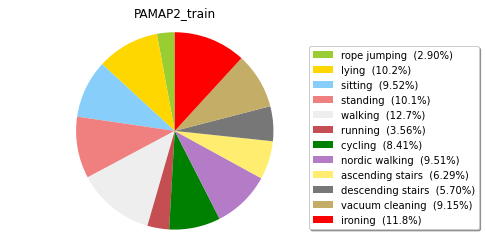

class 0, sample number 50, percentage 1.4%
class 1, sample number 313, percentage 9.0%
class 2, sample number 333, percentage 9.6%
class 3, sample number 309, percentage 8.9%
class 4, sample number 384, percentage 11.0%
class 5, sample number 317, percentage 9.1%
class 6, sample number 301, percentage 8.6%
class 7, sample number 353, percentage 10.1%
class 8, sample number 183, percentage 5.3%
class 9, sample number 161, percentage 4.6%
class 10, sample number 303, percentage 8.7%
class 11, sample number 473, percentage 13.6%


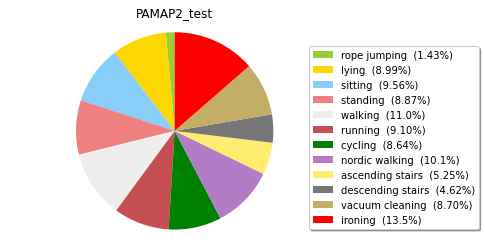

In [30]:
#we're going to visually explore the categories in the data
import matplotlib.pyplot as plt
%matplotlib inline
def drawing_pie_chart(percentages, labels, dataset_id):
    plt.title(dataset_id)
    color_set = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral',
            '#eeeeee','#C44E52', 'green', '#B47CC7','#ffed6f','#777777','#C4AD66','red', 
                  'blue',  'cyan', 'magenta',
                '#FBC15E','#56B4E9','#4878CF','#FFFEA3' ]
    
    labels = labels.copy()
    for i in range(len(percentages)):
        labels[i] = labels[i]+'  ('+str(percentages[i])[:4]+'%)'
    colors = color_set[:len(percentages)]
    
    
    patches, texts = plt.pie(percentages, colors=colors, startangle=90)
    
    plt.axis('equal')
    lgd = plt.legend(labels, loc=(0.9, 0.05), shadow=True, borderaxespad=10.)
    
    
    #plt.savefig('dataset_'+dataset_id+'.eps', bbox_extra_artists=(lgd,), bbox_inches='tight', format='eps', dpi=600)
    plt.show()
    
def calculating_percentages(y_, cNum):
    percentages = np.zeros(cNum)
    for i in range(cNum):
        num = np.sum(y_==i)
        percentages[i]=100.0*num/len(y_)
        print('class {}, sample number {}, percentage {:.1f}%'.format(i, num, percentages[i]))
    return percentages


dataset_id = 'PAMAP2'
labels_PAMAP2 = [r'rope jumping', 
                 r'lying', 
                 r'sitting', 
                 r'standing',
                 r'walking', 
                 r'running', 
                 r'cycling', 
                 r'nordic walking',
                 r'ascending stairs', 
                 r'descending stairs', 
                 r'vacuum cleaning', 
                 r'ironing']
cNum = 12 # 12 classes for PAMAP2


percentages_train = calculating_percentages(y_train0, cNum)
drawing_pie_chart(percentages_train,labels_PAMAP2,dataset_id+'_train')


percentages_test = calculating_percentages(y_test0, cNum)
drawing_pie_chart(percentages_test,labels_PAMAP2,dataset_id+'_test')

Q10: What important facts do this figures tell us?

Q11: Based on this graph, after we trained the model, for which activity do we assume that the model with perform the worst?

Q12: Which figure (or both) do we look at to answer Q11? Why?

Q13: What's the single best thing to do to improve the potential performance of the model?

In [31]:
#The function shapes the data into a size that works for the specific DL model
def _reshaping_Network_input(X, network_type):
    _, win_len, dim = X.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X = np.swapaxes(X,1,2)
        X = np.reshape(X, (-1, dim, win_len, 1))
                
    if network_type=='MLP':
        X = np.reshape(X, (-1, dim*win_len))
    return X

In [32]:
#define the DL part of the convolution neural network  
def model_variant(model, num_feat_map, dim, network_type):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(0.5))
    if network_type == 'CNN':
        
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.5))

#define the convolution part of the convolution neural network       
def model_conv(model, num_feat_map):
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))

#the long-short-term-memory model
def model_LSTM(model):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(0.5))

#the multilayer perceptron model
def model_MLP(model, num_hidden_mlp):
    model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
    model.add(Dropout(0.5))
    model.add(Dense(num_hidden_mlp, activation='relu'))
    model.add(Dropout(0.5))
    

# the structure for the last layer of the model    
def model_output(model):
    model.add(Dense(cNum, activation='softmax'))

## here we define the batch size and hidden layers for MLP and LSTM
## Batch size is a machine learning phrase that refers to the amount of training samples utilised in one iteration.
## The hidden layer enables the neural network to learn categories that are not linearly separable.
## We also enable the CNN model, which is appropriate for sleep detection datasets.

In [33]:

batch_size = 128
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 64

network_type = 'MLP'
network_type = 'CNN'
#network_type = 'LSTM'
#network_type = 'ConvLSTM'


_, win_len, dim = X_train0.shape


In [34]:
#reshaping the data into a size that works for the specific DL model, using the function that we defined before
X_train = _reshaping_Network_input(X_train0, network_type)
X_test = _reshaping_Network_input(X_test0, network_type)
print(X_train.shape)

MLP
MLP
(9466, 2700)


## we apply hot encoding function here, Hot encoding is a common method for preparing categorical information for machine learning models. This form of encoding generates a new binary feature for each potential category and assigns the feature of each sample that corresponds to its original category a value of 1.
## there is  problem with this code , **keras.utils.to_categorical** not used in new versons of keras we need to replace it with  **keras.utils.np_utils.to_categorical**

In [41]:
print('one hot encoding for the labels')
#y_train = keras.utils.to_categorical(y_train0, cNum)
y_train = keras.utils.np_utils.to_categorical(y_train0, cNum)


one hot encoding for the labels


## building the model 

In [42]:


print('building the model ... ')
model = Sequential()


if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map)
    model_variant(model, num_feat_map, dim, network_type)
if network_type=='LSTM':
    model_LSTM(model)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp) 

    
    
    
    
    
model_output(model)    
model.summary()



building the model ... 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               345728    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 12)                1548      
                                                                 
Total params: 363,788
Trainable params: 363,788
Non-trainable params: 0
_________________________________________________________________


## we define the epoch number here (epochs = 5) ,An epoch is a phrase used in machine learning that denotes the number of passes the machine learning algorithm has made across the full training dataset. Typically, datasets are organised into batches ,especially when the amount of data is very large

In [43]:

epochs = 5

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

H = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True)

Epoch 1/5
74/74 [==============================] - 1s 5ms/step - loss: 1.7411 - accuracy: 0.4911
Epoch 2/5
74/74 [==============================] - 0s 6ms/step - loss: 1.0346 - accuracy: 0.6846
Epoch 3/5
74/74 [==============================] - 0s 6ms/step - loss: 0.8057 - accuracy: 0.7601
Epoch 4/5
74/74 [==============================] - 0s 7ms/step - loss: 0.6810 - accuracy: 0.7908
Epoch 5/5
74/74 [==============================] - 1s 7ms/step - loss: 0.5892 - accuracy: 0.8202


In [44]:
from time import time
from sklearn.metrics import f1_score
t0 = time()
y_probabilities = model.predict(X_test)
y_pred = np.argmax(y_probabilities, axis=1)
print(str((time()-t0)*1000/len(y_pred))+' ms/frame')
y_test = y_test0.copy()
mean_f1 = f1_score(y_test, y_pred, average='macro')  
print(network_type+'     mean-f1: {:.2f}'.format(mean_f1))



    

0.11949258289117923 ms/frame
MLP     mean-f1: 0.76


Q18: we just imported another metric to assess the performance of the model on the test set. What metric did we use for the training? Why don't we use that same metric? 

In [45]:
print(X_test.shape)

(3480, 2700)


In [95]:

rand_test_id = np.random.randint(0, len(X_test)-1)
print('the randomly selected test_id: '+str(rand_test_id))

the randomly selected test_id: 1608


**there was index error here, i fix the issue**

In [ ]:
current_test_data0 = X_test[rand_test_id,:,:,0]
#current_test_data0 = X_test[rand_test_id,0]
print('getting the current test frame')

In [ ]:
print('visualising the current test frame')
fig = plt.figure()
plt.title('Current window: channel number: 27, length: 100')
plt.plot(np.transpose(current_test_data0))
plt.show()

In [88]:
print('defining a a query function, that can output the probability distribution given the current frame')
 
def query_model(current_test_data, model):
    if network_type=='CNN' or network_type=='ConvLSTM':
        print('reshaping test_data')
        current_test_data_4d = np.reshape(current_test_data, (-1, dim, win_len, 1))
        print('working on the prediction...')
        prob_dist = model.predict(current_test_data_4d)
    else: 
        print('current version only work on CNN/ConvLSTM structure!')
    return prob_dist -1


defining a a query function, that can output the probability distribution given the current frame


In [ ]:
prob_dist = query_model(current_test_data0, model)
print('given the query frame, the output probabilities for all classes:')
print(prob_dist)

In [ ]:
c = np.arange(cNum) # cNum: number of classes, 12 for PAMAP2 dataset
color_set = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral',
        '#C44E52', 'green', '#B47CC7','#777777','#C4AD66','red', 
                  'blue',  'cyan', 'magenta',
                '#FBC15E','#56B4E9','#4878CF','#FFFEA3' ]


colors = color_set[:cNum]
fig, ax = plt.subplots()
_bar = ax.bar(c, 100*prob_dist.flatten(), color=colors)
ax.legend(_bar, (labels_PAMAP2), loc=(1.1, 0.05), shadow=True, borderaxespad=10)
ax.set_ylabel('(%)')
ax.set_title('prediction probability distribution')
ax.set_xticks(c)
plt.show()


In [ ]:

y_pred = np.argmax(prob_dist, axis=1)
print('predicted activity: '+labels_PAMAP2[int(y_pred)])

In [ ]:
print('ground truth: '+labels_PAMAP2[int(y_test[rand_test_id])])